# Machine learning for texts

Online store launches a new service. Now users can edit and supplement product descriptions, just like in wiki communities. That is, clients propose their edits and comment on the changes of others. The store needs a tool that will look for toxic comments and submit them for moderation.  At our disposal is a dataset with markup on the toxicity of edits.


**Project objectives**

1. Download and prepare data.
2. Train different models to classify comments into positive and negative.
3. Build a model with a quality metric *F1* of at least 0.75.
4. Draw conclusions.


**Data Description**

The data is in the `toxic_comments.csv` file. The *text* column contains the text of the comment, and *toxic* is the target attribute.

## Data preparation

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import time


import re
import nltk 
from nltk.stem import WordNetLemmatizer 
from nltk.corpus import stopwords as nltk_stopwords
from sklearn.feature_extraction.text import TfidfVectorizer


from sklearn.model_selection import train_test_split, GridSearchCV
from lightgbm import LGBMClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

import warnings
warnings.filterwarnings("ignore")

Examining the data.

In [2]:
try:
    df = pd.read_csv('toxic_comments.csv')
except:
    df = pd.read_csv('/datasets/toxic_comments.csv')

In [3]:
df.head()

,Unnamed: 0,text,toxic
0,0,Explanation\nWhy the edits made under my usern...,0
1,1,D'aww! He matches this background colour I'm s...,0
2,2,"Hey man, I'm really not trying to edit war. It...",0
3,3,"""\nMore\nI can't make any real suggestions on ...",0
4,4,"You, sir, are my hero. Any chance you remember...",0


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159292 entries, 0 to 159291
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   Unnamed: 0  159292 non-null  int64 
 1   text        159292 non-null  object
 2   toxic       159292 non-null  int64 
dtypes: int64(2), object(1)
memory usage: 3.6+ MB


In [5]:
df.duplicated().sum()

0

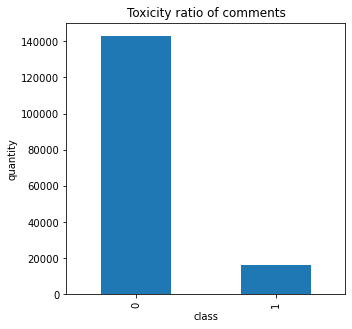

In [6]:
df['toxic'].value_counts().plot(kind='bar', figsize = (5,5))
plt.title('Toxicity ratio of comments')
plt.ylabel('quantity')
plt.xlabel('class');

The ratio of classes is uneven. It is necessary to keep the imbalance in training.

Data of about 159 thousand unique values is at our disposal, located in three columns `Unnamed:0`, `text`, and `toxic`.

The language of the text is English, the texts contain punctuation marks, capital letters, symbols. It is necessary to lemmatize the text.

In [7]:
lemmatizer = WordNetLemmatizer()
def lemmatization(text):
    word_list = nltk.word_tokenize(text)
    return ' '.join([lemmatizer.lemmatize(w) for w in word_list])

In [8]:
def clear_text(text):
    return ' '.join(re.sub(r'[^a-z]', ' ',text.lower()) .split())

In [9]:
df['text'] = df['text'].apply(lemmatization)
df['text'] = df['text'].apply(clear_text)

In [10]:
df.head()

,Unnamed: 0,text,toxic
0,0,explanation why the edits made under my userna...,0
1,1,d aww he match this background colour i m seem...,0
2,2,hey man i m really not trying to edit war it s...,0
3,3,more i ca n t make any real suggestion on impr...,0
4,4,you sir are my hero any chance you remember wh...,0


- The data has been studied, it is possible to keep an imbalance in the target features.
- Lemmatization has been performed.
- Data is ready for training. 


## Model training

Dividing the dataset into training and test samples in the ratio of 75:25. 

In [11]:
features = df.drop(['toxic'], axis=1)
target = df['toxic']

In [12]:
train, test = train_test_split(df, test_size=0.25, random_state=12345, stratify=target)

In [13]:
features_train = train.drop(['toxic'], axis=1)
target_train = train['toxic']
features_test = test.drop(['toxic'], axis=1)
target_test = test['toxic']

In [14]:
corpus_train = features_train['text'].values
corpus_test = features_test['text'].values

Creating a counter.

In [15]:
stopwords = set(nltk_stopwords.words('english'))
count_tf_idf = TfidfVectorizer(stop_words=stopwords, min_df=3, max_df=0.9)

Calculating TF-IDF. 

In [16]:
features_train = count_tf_idf.fit_transform(corpus_train)
features_test = count_tf_idf.transform(corpus_test)

Moving on to model training, LogisticRegression и LGBMClassifier are chosen.

In [17]:
def best_model(model, params, features_train, target_train, features_test, target_test):
    grid = GridSearchCV(model, param_grid = params, cv=2, verbose=True,
                                            scoring = 'f1', n_jobs=-1)
    grid.fit(features_train,target_train)
    predict = grid.predict(features_test)
    return f1_score(target_test, predict), grid.best_params_

In [18]:
start = time.time()
model_lr = LogisticRegression(random_state=12345, class_weight='balanced')
lr_params = {'C': [8,15]}
lr = best_model(model_lr, lr_params, features_train, target_train, features_test, target_test)
end = time.time()
lr_time = end - start 
print(f"F1 and the best parameters: {lr}")

Fitting 2 folds for each of 2 candidates, totalling 4 fits
F1 and the best parameters: (0.7555058692006708, {'C': 8})


In [19]:
start = time.time()
model_lgbm = LGBMClassifier(metric = 'f1_score')
lgbm_params = {'max_depth': [1,10],
               'n_estimators': [10, 30], 
                'learning_rate': [0.1]
              }
lgbm = best_model(model_lgbm, lgbm_params, features_train, target_train, features_test, target_test)
end = time.time()
lgbm_time = end - start
print(f"F1 and the best parameters: {lgbm}")

Fitting 2 folds for each of 4 candidates, totalling 8 fits
F1 and the best parameters: (0.59660441426146, {'learning_rate': 0.1, 'max_depth': 10, 'n_estimators': 30})


## Summary

Comparing F1 и training and prediction time. 

In [20]:
table = pd.DataFrame({
    'model': ['LogisticRegression','LightGBM'],
    'time' : [ lr_time, lgbm_time ] , 
    'F1': [lr, lgbm]
})


In [21]:
table

,model,time,F1
0,LogisticRegression,26.133034,"(0.7555058692006708, {'C': 8})"
1,LightGBM,93.051486,"(0.59660441426146, {'learning_rate': 0.1, 'max..."


F1 of Logistic Regression is higher. It equals 0.75. The goal is achieved.

During the work, the following was done:
    
- The data has been studied, there is an imbalance in the toxicity of comments.
- Lemmatization of texts has been completed, symbols, capital letters and sing marks have been removed.
- Texts were trained using `LogisticRegression` and `LightGBM`.
- `LogisticRegression` showed a good result F1, more than 0.75 when C = 8.